---
# Data Collection
---

In [360]:
# These values can be changed to the requested ticker and parameters 

ticker = 'GS'
from_date = '2010-01-01'
to_date = '2018-12-31'
type = 'line'

competitors = ['JPM', 'MS', 'C', 'BCS', 'CS', 'UBS', 'DB']


In [361]:
# Helper: Financial API helper functions    #

from urllib.request import urlopen
import urllib.parse
import json

# Get JSON data from the requested url
def get_json_data(url):
    response = urlopen(url)
    response = response.read().decode("utf-8")
    return json.loads(response)

# Conver the provided parameters into FMP url
def get_url(ticker, from_date = None, to_date = None, type = None):
    url = "https://financialmodelingprep.com/api/v3/historical-price-full/" + urllib.parse.quote(ticker, safe='=:/&?') + "?"
    
    params = ''
    if from_date != None:
        params += 'from=' + from_date + "&"
    if to_date != None:
        params += 'to=' + to_date + '&'
    if type != None:
        params += 'serietype=' + type + '&'

    return url + urllib.parse.quote(params[:-1], safe='=:/&?')

json_data = get_json_data(get_url(ticker, from_date, to_date, type))


In [362]:
# Write ticker data to file as csv #
import csv

# Write JSON data to csv file
data_file = open('dataset.csv', 'w+')
outputWriter = csv.writer(data_file, delimiter=',')

outputWriter.writerow(['date', ticker])
for obj in json_data['historical']:
    outputWriter.writerow([obj['date'] , obj['close']])

data_file.close()

---
# Data Preprocessing
---



In [363]:
# Supposedly all imports

# from utils import *

import time
import numpy as np

import pandas as pd

# from mxnet import nd, autograd, gluon
# from mxnet.gluon import nn, rnn
# import mxnet as mx
import datetime
# import seaborn as sns

import matplotlib.pyplot as plt
# %matplotlib inline
# from sklearn.decomposition import PCA

# import math

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler

# import xgboost as xgb
# from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")




In [364]:
complete_dataset = pd.read_csv('dataset.csv')
total_days = complete_dataset.shape[0]
num_training_days = int(total_days * .7)
num_testing_days = total_days-num_training_days
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, num_testing_days))



There are 2264 number of days in the dataset.
Number of training days: 1584. Number of test days: 680.


In [365]:
# Optional: Print timeseries of data #

# plt.figure(figsize=(14, 5), dpi=100)
# plt.plot(complete_dataset['date'], complete_dataset[ticker], label='{ticker} stock')
# plt.vlines(str(datetime.date(2016, 4, 20)), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
# plt.xlabel('Date')
# plt.ylabel('USD')
# plt.title('Figure 2: Goldman Sachs stock price')
# plt.legend()
# plt.show()

In [366]:
# Helper: Appends additional features to main data file #

def merge_data(json_data):
    diff1 = pd.read_csv('dataset.csv')
    diff2 = pd.DataFrame(json_data)

    diff = diff1.merge(diff2, on=diff1.columns.intersection(diff2.columns).to_numpy().tolist(), right_index=False, left_index=True, how='left')
    diff.to_csv('dataset.csv', index=False)
    

## Correlated Assets
---

### Similar Companies or Competitors

In [367]:
# Add similar companies data to dataset #

json_data = None

for c in competitors:
    json_data = get_json_data(get_url(c, from_date, to_date, type))
    
    # Change 'close' to the company name
    json_data = json_data['historical']
    for i in range(len(json_data)):
        json_data[i][c] = json_data[i].pop('close')

    merge_data(json_data)

complete_dataset = pd.read_csv('dataset.csv')
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))


There are 2264 number of days in the dataset.


### Volatility Index

In [368]:
# Add volatility index to the dataset #

json_data = None

json_data = get_json_data(get_url('index/^VIX', from_date, to_date, type))

# Change 'close' to the volatility index
json_data = json_data['historical']
for i in range(len(json_data)):
    json_data[i]['^VIX'] = json_data[i].pop('close')

merge_data(json_data)

complete_dataset = pd.read_csv('dataset.csv')
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))


There are 2264 number of days in the dataset.


### Global Economic and Composite Indices

In [369]:
# Add major worldwide indexes to dataset #

major_indices = ['^DJI', '^IXIC', '^GSPC', '^BSESN', '^FTSE', '^N225', '^HSI', '^BVSP', '^BUK100P', '^N100']
json_data = None

for ind in major_indices:
    json_data = get_json_data(get_url('index/' + ind, from_date, to_date, type))
   
    # Change 'close' to the volatility index
    json_data = json_data['historical']
    for i in range(len(json_data)):
        json_data[i][ind] = json_data[i].pop('close')

    merge_data(json_data)

complete_dataset = pd.read_csv('dataset.csv')
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))


There are 2264 number of days in the dataset.


### FI Securities and Treasury Yield ETFs

In [370]:
# Add fixed income securities and goverment treasury yields to data #

gov_sec = ['VGLT', 'VGSH', 'VGIT', 'SPTS', 'JPST', 'VCSH', 'VCIT', 'VMBS', 'JNK']
json_data = None

for ind in gov_sec:
    json_data = get_json_data(get_url(ind, from_date, to_date, type))
   
    # Change 'close' to the volatility index
    json_data = json_data['historical']
    for i in range(len(json_data)):
        json_data[i][ind] = json_data[i].pop('close')

    merge_data(json_data)

complete_dataset = pd.read_csv('dataset.csv')
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))

There are 2264 number of days in the dataset.


### Currencies

In [371]:

# Add ForEx data to dataset

currencies = ['USDJPY', 'USDGBP', 'USDEUR', 'USDCHF', 'USDCAD']

json_data = None

for c in currencies:
    json_data = get_json_data(get_url('forex/' + c, from_date, to_date, type))

    # Change 'close' to the volatility index
    json_data = json_data['historical']
    for i in range(len(json_data)):
        json_data[i][c] = json_data[i].pop('close')

    merge_data(json_data)

complete_dataset = pd.read_csv('dataset.csv')
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))

There are 2264 number of days in the dataset.


## Technical Indicators
---


In [372]:
complete_dataset = pd.read_csv('dataset.csv')

In [373]:
import math

def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset[ticker].rolling(window=7).mean()
    dataset['ma21'] = dataset[ticker].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset[ticker].ewm(span=26).mean()
    dataset['12ema'] = dataset[ticker].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset[ticker].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset[ticker].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset[ticker] - 1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    
    return dataset

technical_dataset = get_technical_indicators(complete_dataset[['date', ticker]])

complete_dataset = complete_dataset.merge(technical_dataset, on=complete_dataset.columns.intersection(technical_dataset.columns).to_numpy().tolist(), right_index=False, left_index=True, how='left')
complete_dataset.to_csv('dataset.csv', index=False)

complete_dataset = pd.read_csv('dataset.csv')
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))

There are 2264 number of days in the dataset.


In [374]:
# Optional: Plots Bollinger bands and other info on price graph

# def plot_technical_indicators(dataset, last_days):
#     plt.figure(figsize=(16, 10), dpi=100)
#     shape_0 = dataset.shape[0]
#     xmacd_ = shape_0-last_days
    
#     dataset = dataset.iloc[-last_days:, :]
#     x_ = range(3, dataset.shape[0])
#     x_ =list(dataset.index)
    
#     # Plot first subplot
#     plt.subplot(2, 1, 1)
#     plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
#     plt.plot(dataset[ticker],label='Closing Price', color='b')
#     plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
#     plt.plot(dataset['upper_band'],label='Upper Band', color='c')
#     plt.plot(dataset['lower_band'],label='Lower Band', color='c')
#     plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
#     plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
#     plt.ylabel('USD')
#     plt.legend()

#     # Plot second subplot
#     plt.subplot(2, 1, 2)
#     plt.title('MACD')
#     plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

#     plt.legend()
#     plt.show()

# plot_technical_indicators(technical_dataset, 400)


## Fundamental Analysis
---

### Company Analysis

### Sentiment Analysis

## Trend Analysis
---

In [356]:
# Fourier function to generate data points after fourier transformation #

fourier_dataset = complete_dataset[['date', ticker]]

dates = fourier_dataset['date']
close_fft = np.fft.fft(np.asarray(fourier_dataset[ticker].tolist()))
fft = pd.DataFrame({'fft':close_fft})
fft['absolute'] = fft['fft'].apply(lambda x: np.abs(x))
fft['angle'] = fft['fft'].apply(lambda x: np.angle(x))


In [357]:
# Fourier Components for Short-Term, Mid-Term and Long-Term Trend prediction #

short_term_trend = 50
mid_term_trend = 9
long_term_trend = 4


In [358]:
# Generate data points after fourier transformation using fourier function #

dates = fourier_dataset['date']

# Short-Term
fft_copy = np.copy(np.asarray(fft['fft'].tolist()))
fft_copy[short_term_trend:-short_term_trend] = 0
temp_list = np.fft.ifft(fft_copy)
df = pd.DataFrame(data=temp_list, columns=['fourier_short'])
dates = pd.concat([dates, df], axis=1)

# Mid-Term
fft_copy = np.copy(np.asarray(fft['fft'].tolist()))
fft_copy[mid_term_trend:-mid_term_trend] = 0
temp_list = np.fft.ifft(fft_copy)
df = pd.DataFrame(data=temp_list, columns=['fourier_mid'])
dates = pd.concat([dates, df], axis=1)

# Long-Term
fft_copy = np.copy(np.asarray(fft['fft'].tolist()))
fft_copy[long_term_trend:-long_term_trend] = 0
temp_list = np.fft.ifft(fft_copy)
df = pd.DataFrame(data=temp_list, columns=['fourier_long'])
dates = pd.concat([dates, df], axis=1)

# Merge with complete dataset
complete_dataset = complete_dataset.merge(dates, on=complete_dataset.columns.intersection(dates.columns).to_numpy().tolist(), right_index=False, left_index=True, how='left')
complete_dataset.to_csv('dataset.csv', index=False)

complete_dataset = pd.read_csv('dataset.csv')
print('There are {} number of days in the dataset.'.format(complete_dataset.shape[0]))

There are 2264 number of days in the dataset.


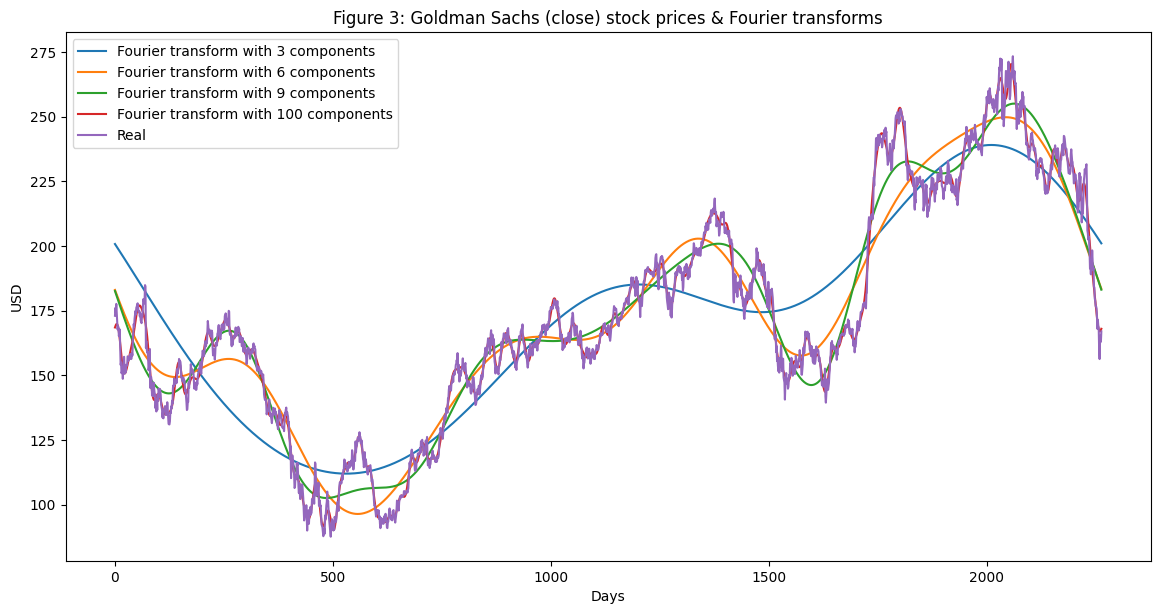

In [359]:
# Optional: Plot the timeseries with the fourier transform components

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); 
    fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(fourier_dataset[ticker],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()